In [1]:
import os, glob
import re, shutil
from tqdm import tqdm
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 as ToTensor
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random



In [2]:
# !pip install -r requirements_uavUnet.txt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/Forest/src/

In [4]:
# チェックポイントファイルのパス
# checkpoint_path = '04_trainingModel/data168_modelResize-0512_batch8_epoch100_class-cypress/chkpoint_'
checkpoint_path = '04_trainingModel/data2016_modelResize-0256_batch32_epoch200_class-cypress/bestmodel.pt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available(),device)

# 入力画像のパス
image_path = '03_datasetforModel/Forest tsumura 2 50m P4Pv2_cypress/org_crop4Corner_5120_3072_Size1024_lap512/DJI_0065_01_upperL_rect_X00512to01536_Y02048to03072.jpg'

from u_net_pytorch import UNet, load_ckp
from u_net_pytorch import format_image, format_mask
from fpathutils import get_mskPath

# チェックポイントファイルの読み込み
model = UNet(3,1)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)


if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))
    print("ckpt Loaded cuda")
else:
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    print("ckpt Loaded cpu")

model.to(device)

# model.load_state_dict(checkpoint['state_dict'])
# model.eval()
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

print("model, ckpt Loaded")


# def p_calc(img):
#     print(img.max(),img.min(),img.mean())
# mean_values, std_deviation = np.array([0.29874884,0.53215061,0.40219877]), np.array([0.14500768, 0.21275673, 0.1953213 ])
mean_values, std_deviation = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])#デフォルト値


True cuda:0
ckpt Loaded cuda
model, ckpt Loaded


<Figure size 640x480 with 0 Axes>

In [6]:
# from u_net_pytorch import get_train_transform

def get_train_transform(resizeValue):
   return A.Compose(
       [
        #リサイズ(こちらはすでに適用済みなのでなくても良いです)
        A.Resize(resizeValue, resizeValue),
        #正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Normalize(),
        #水平フリップ（pはフリップする確率）
        # A.HorizontalFlip(p=0.25),
        #垂直フリップ
        # A.VerticalFlip(p=0.25),
        ToTensor()
        ])


class LoadPredDataSet(Dataset):
        def __init__(self,imgPaths,resizeValue, transform=None):
            self.path = imgPaths
            self.folders = [os.path.basename(imgPath) for imgPath in imgPaths]
            self.transforms = get_train_transform(resizeValue)
            self.resizeValue = resizeValue

        def __len__(self):
            return len(self.folders)


        def __getitem__(self, idx):
            image_path = self.path[idx]
            # mask_path = get_mskPath(self.path[idx])
            resizeValue = self.resizeValue

            #画像データの取得
            img = io.imread(image_path)[:,:,0:3].astype('float32')
            img = transform.resize(img,(resizeValue,resizeValue))

            # mask = self.get_mask(mask_path, resizeValue, resizeValue ).astype('float32')


            augmented = self.transforms(image=img)
            # augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            # mask = augmented['mask']
            # mask = mask.permute(2, 0, 1)


            # # 可視化
            # figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(5, 8))
            # ax[0,0].imshow(img.permute(1, 2, 0))#img画像は正規化しているため色味がおかしい
            # ax[0,1].imshow(mask[0,:,:])

            return img, image_path


In [8]:
imageDir = os.path.dirname(image_path)

imgPaths = glob.glob(os.path.join(imageDir,"*.jpg"))
print(len(imgPaths))

modelID = os.path.basename(os.path.dirname(checkpoint_path))
savePath = os.path.join("05_predicted",modelID)
os.makedirs(savePath,exist_ok=True)

168


tensor([0.0000e+00, 2.9648e-39, 3.0553e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0')
03_datasetforModel/Forest tsumura 2 50m P4Pv2_cypress/org_crop4Corner_5120_3072_Size1024_lap512\DJI_0673_01_upperL_rect_X01024to02048_Y01536to02560.jpg


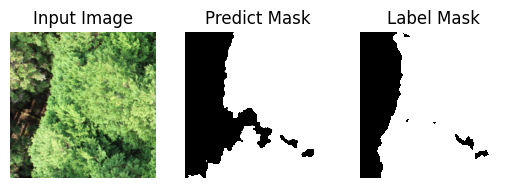

tensor([0.0000e+00, 3.0433e-39, 4.0763e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0')
03_datasetforModel/Forest tsumura 2 50m P4Pv2_cypress/org_crop4Corner_5120_3072_Size1024_lap512\DJI_0314_01_upperL_rect_X00000to01024_Y02048to03072.jpg


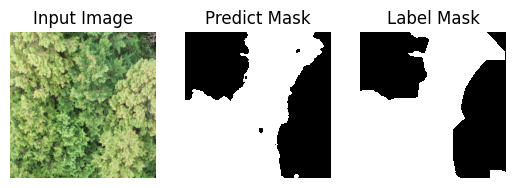

tensor([2.9339e-30, 3.0448e-30, 5.1926e-30,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0')
03_datasetforModel/Forest tsumura 2 50m P4Pv2_cypress/org_crop4Corner_5120_3072_Size1024_lap512\DJI_0460_01_upperL_rect_X00512to01536_Y01536to02560.jpg


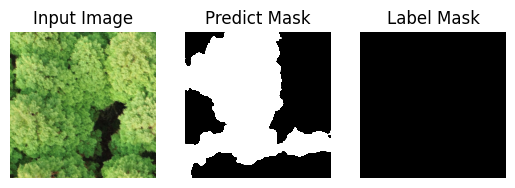

tensor([3.0297e-39, 8.1683e-39, 5.5717e-38,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0')
03_datasetforModel/Forest tsumura 2 50m P4Pv2_cypress/org_crop4Corner_5120_3072_Size1024_lap512\DJI_0804_01_upperL_rect_X01024to02048_Y00000to01024.jpg


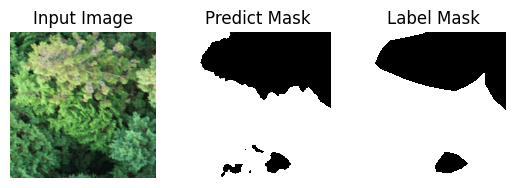

tensor([0.0000e+00, 2.9930e-39, 3.0595e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0')
03_datasetforModel/Forest tsumura 2 50m P4Pv2_cypress/org_crop4Corner_5120_3072_Size1024_lap512\DJI_0673_01_upperL_rect_X02048to03072_Y02048to03072.jpg


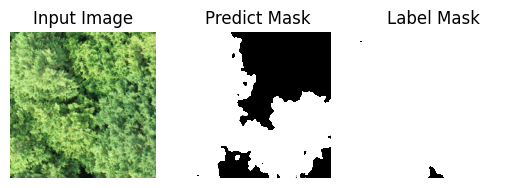

In [18]:
def predictImage(model,resizeValue,imgPaths, pickMaskPath=False):

    pred_dataset = LoadPredDataSet(imgPaths, resizeValue, transform=get_train_transform(resizeValue))

    image,image_path = pred_dataset.__getitem__(1)

    # GPUを使用する場合
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print("torchDevice",device)
    # model = model.to(device)

    pred_loader = DataLoader(dataset=pred_dataset, batch_size=1, shuffle=False)
    for image,image_path in pred_loader:
        image_path = image_path[0]#DataLoaderから取得するとtupleで返るので0で取る
        image = image.to(device)
        # image = torch.autograd.Variable(image).cuda()
        # mask = torch.autograd.Variable(mask).cuda()



        # 予測の実行
        with torch.no_grad():
            predict = model(image)

        # print(predict.shape)
        # 出力の後処理
        # print(predict.unique())
        # argmax：指定した次元において最大値を持つ要素のインデックスを返す関数です。
        # predict = torch.argmax(predict, dim=1)  # 分類問題の場合、予測クラスの取得など
        print(predict.unique())
        # print(image.shape)
        image = image.data.cpu().numpy()#(1,3,imgsize,imgsize)
        image = np.squeeze(image)#(3,imgsize,imgsize)
        predict = predict.data.cpu().numpy()#(1,1,imgsize,imgsize)
        predict = np.squeeze(predict)#(imgsize,imgsize)

        # # ヒストグラムをプロット
        # predict_100 = (predict*100).astype("int64")
        # histogram = np.histogram(image, range(101))
        # count, values = histogram[0], histogram[1]
        # print(len(count),len(values))

        # count = list(count)
        # count.append(100000)
        # count = np.array(count)
        # df = pd.DataFrame(data={"count":count,"predict_values":values})
        # df.to_csv(os.path.join(savePath,f"histgramList_{os.path.basename(image_path)}.csv"))

        # plt.figure()
        # print(np.unique(predict_100))
        # print(histogram)
        # plt.bar(histogram[1][:-1], histogram[0])
        # plt.xlabel('Pixel Value')
        # plt.ylabel('Frequency')
        # plt.title('Histogram')
        # plt.savefig(os.path.join(savePath,f"histgram_{os.path.basename(image_path)}"))
        # # plt.show()


        predict = np.expand_dims(predict,axis=-1)#(1,imgsize,imgsize)

        img = format_image(image)
        # pred = format_mask(predict)
        pred = predict
        if pickMaskPath==True:
            print(image_path)
            mskPath = get_mskPath(image_path)
            # print(mskPath)
            msk = np.array(Image.open(mskPath))
            figure, ax = plt.subplots(1,3)
            # print(images)
            ax[0].imshow(img)
            ax[1].imshow(pred, interpolation="nearest", cmap="gray")
            ax[2].imshow(msk, interpolation="nearest", cmap="gray")
            ax[0].set_title("Input Image")
            ax[1].set_title("Predict Mask")
            ax[2].set_title("Label Mask")
            ax[0].set_axis_off()
            ax[1].set_axis_off()
            ax[2].set_axis_off()

        else:
            figure, ax = plt.subplots(1,2)
            # print(images)
            ax[0].imshow(img)
            ax[1].imshow(pred, interpolation="nearest", cmap="gray")
            ax[0].set_title("Input Image")
            ax[1].set_title("Predict Mask")
            ax[0].set_axis_off()
            ax[1].set_axis_off()
        # plt.tight_layout()
        plt.show()


predictImage(model, 256, imgPaths=random.sample(imgPaths,5), pickMaskPath=True)


In [45]:
fileNameParts = os.path.basename(imgPaths[3]).split("_")
print(fileNameParts)
UAVImageName =  f"{fileNameParts[0]}_{fileNameParts[1]}"
separatePositionName = f"{fileNameParts[2]}{fileNameParts[3]}_{fileNameParts[4]}"
cropPositionName = f"{fileNameParts[5]}_{fileNameParts[6]}".replace(".jpg","")

print(UAVImageName,cropPositionName,cropPositionName)

['DJI', '0314', '01', 'upperL', 'rect', 'X00000to01024', 'Y01536to02560.jpg']
DJI_0314 X00000to01024_Y01536to02560 X00000to01024_Y01536to02560


In [48]:
def getOrgImgInfo(imgName:str):
    pattern = f".\\03_datasetforModel\\Forest tsumura 2 50m P4Pv2_cypress\\org\\{imgName}.JPG"
    imagePaths = glob.glob(pattern)
    
    if len(imagePaths)==1:
        with Image.open(imagePaths[0]) as img:
            width, height = img.size
        return imagePaths[0], width, height
    else:
        print("Not match fileName",pattern)
        return ""


('.\\03_datasetforModel\\Forest tsumura 2 50m P4Pv2_cypress\\org\\DJI_0314.JPG',
 5472,
 3648)

In [50]:
def twoImgShow(img1_pil,img2_pil):
    img1 = np.array(img1_pil)
    img2 = np.array(img2_pil)
    plt.subplot()

orgPath_uav, width_uav, height_uav = getOrgImgInfo(UAVImageName)

imgCanvas = Image.new('L',[width_uav,height_uav])
imgCanvas.size

(5472, 3648)

In [ ]:

    print(ImgName, "を予測しています。")
    org_img = Image.open(predictImgPath)
    width , height = org_img.size
    print(width , height)

    resizeForSlideSize = resizeSize(org_img,SlideSize)

    # 予測結果を貼り付ける先のキャンバス作成
    imgCanvas = Image.new('RGB',resizeForSlideSize)
    imgCanvas_org = imgCanvas.copy()
    imgCanvas_prd = Image.new('L',resizeForSlideSize)
    print("imgCanvas type", type(imgCanvas))
    print("imgCanvas", imgCanvas)


    #画像サイズとクリップサイズで切りがいい画素サイズにリサイズする。
    org_img_resize = org_img.resize(resizeSize(org_img,SlideSize))

    #分割画像サイズ　と　スライドサイズに応じて、元画像の縦横幅から、縦横の分割数を計算して取得
    xl = (width - (imgWidth - SlideSize))// SlideSize
    yl = (height - (imgWidth - SlideSize))// SlideSize
    print("水平方向 xl: " + str(xl) + "  垂直方向 yl " + str(yl))

  
  
    #元画像1枚に対する処理
    for x in range (xl):
        for y in range(yl):

            box = (x*SlideSize,y*SlideSize,x*SlideSize+imgWidth,y*SlideSize+imgWidth)

            org_img_resize_crop = org_img_resize.crop(box)


            imgCanvas_org.paste(org_img_resize_crop, (x * SlideSize, y * SlideSize))


            # 元画像を変換して、モデルで予測を実行する。
            raw_orgResizeNp = np.array(org_img_resize_crop.resize(imgSize))/255
            raw_orgNp = raw_orgResizeNp[:,:,0:3]            
            prd_crop_img = model.predict(np.expand_dims(raw_orgNp, 0))




            # numpyで0-1のマスク画像を0-255に変換
            prd_crop_img = prd_crop_img.squeeze()
#             prd_crop_img = np.stack((prd_crop_img,)*3, axis=-1)


            print("prd_crop_img--",type(prd_crop_img),prd_crop_img.shape, np.unique(prd_crop_img))
            plt.imshow(prd_crop_img)
            
            prd_crop_img = np.argmax(prd_crop_img, axis=-1)

            plt.imshow(prd_crop_img)
            print("prd_crop_img--",type(prd_crop_img),prd_crop_img.shape, np.unique(prd_crop_img))
    
    
#             prd_crop_img[prd_crop_img >= 0.5] = 255 
#             prd_crop_img[prd_crop_img < 0.5] = 0 


            #　numpy→PILへ変換してキャンバスに貼り付け          
            prd_crop_img = Image.fromarray(np.uint8(prd_crop_img))
            
            imgCanvas_prd.paste(prd_crop_img, (x * SlideSize, y * SlideSize))


  
#     imgShowPlt(imgCanvas_org)
#     imgShowPlt(imgCanvas_prd)

    plt.imshow(np.array(imgCanvas_prd))
    

    #予測結果を元画像サイズで保存
    width , height = org_img.size  

    imgCanvas_org = imgCanvas_org.resize((width , height))
    imgCanvas_prd = imgCanvas_prd.resize((width , height))  


    print(predictMaskImgSavePaths + ImgName[:-4] + "_prd.jpg")
    print(predictImgSavePaths + ImgName[:-4] + "_org.jpg")
    imgCanvas_org.save(predictImgSavePaths + ImgName[:-4] + "_org.jpg")
    imgCanvas_prd.save(predictMaskImgSavePaths + ImgName[:-4] + "_prd.jpg")


    src = Image.open(predictImgSavePaths + ImgName[:-4] + "_org.jpg")
    mask = Image.open(predictMaskImgSavePaths + ImgName[:-4] + "_prd.jpg").convert("L")

    #背景は真っ黒にする
    zeroGray = Image.new("L", src.size, 0)

    #元画像と予測マスク画像を合成する。
    prdOrg = Image.composite(zeroGray, src, mask)

    plt.imshow(np.array(prdOrg))
    prdOrg.save(predictImgSavePaths + ImgName[:-4] + "_orgprd.jpg")

